In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DeepFundingMini/HuggingFace

/content/drive/MyDrive/DeepFundingMini/HuggingFace


In [ ]:
# !wget -O deepfundutils.py https://raw.githubusercontent.com/hara-desu/DeepFundingMiniContest/refs/heads/main/code/deepfundutils.py

--2025-01-15 17:29:39--  https://raw.githubusercontent.com/hara-desu/DeepFundingMiniContest/refs/heads/main/code/deepfundutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7197 (7.0K) [text/plain]
Saving to: ‘deepfundutils.py’

deepfundutils.py    100%[===================>]   7.03K  --.-KB/s    in 0s      

2025-01-15 17:29:39 (13.8 MB/s) - ‘deepfundutils.py’ saved [7197/7197]



In [ ]:
import warnings
import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

from deepfundutils import model_eval, fix_pred_range, label_encode_ab

# warnings.filterwarnings('ignore')

In [ ]:
splits = {'train': 'train.parquet', 'test': 'test.parquet'}

df_train = pd.read_parquet('hf://datasets/evalscience/deepfunding-mini/' + splits['train'])
df_valid = pd.read_parquet('hf://datasets/evalscience/deepfunding-mini/' + splits['test'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df_train

,id,project_a,project_b,weight_a,weight_b,maintainer_a,language_a,is_fork_a,created_at_a,updated_at_a,...,num_packages_b,num_dependents_in_oso_b,list_of_dependents_in_oso_b,list_of_packages_b,list_of_funders_b,total_funding_usd_b,total_funding_usd_since_2023_b,oso_dependency_rank_b,num_repos_in_same_language_b,oso_dependency_rank_for_language_b
0,2,https://github.com/prettier-solidity/prettier-...,https://github.com/nomicfoundation/hardhat,0.101669,0.898331,prettier-solidity,Solidity,False,2018-05-15,2024-12-10,...,12,757,"[ora-io, levi0214, unitapapp, foundry-rs, cand...","[NPM/@nomicfoundation/hardhat-web3-v4, NPM/@no...","[Gitcoin, Optimism]",1.196182e+06,9.811566e+05,0.576301,239,0.554622
1,3,https://github.com/prettier-solidity/prettier-...,https://github.com/consensys/teku,0.669446,0.330554,prettier-solidity,Solidity,False,2018-05-15,2024-12-10,...,0,0,[],[],"[Gitcoin, Optimism]",1.207678e+05,1.173000e+05,0.000000,2,0.000000
2,4,https://github.com/prettier-solidity/prettier-...,https://github.com/ethereum/solidity,0.449022,0.550978,prettier-solidity,Solidity,False,2018-05-15,2024-12-10,...,0,0,[],[],"[Gitcoin, Optimism]",2.164564e+06,2.164563e+06,0.000000,11,0.000000
3,5,https://github.com/prettier-solidity/prettier-...,https://github.com/ethereum/remix-project,0.498396,0.501604,prettier-solidity,Solidity,False,2018-05-15,2024-12-10,...,7,14,"[artblocks, starboard-ventures, zcloak-network...","[NPM/@remix-project/remixd, NPM/@remix-project...","[Gitcoin, Optimism]",1.109272e+06,1.109271e+06,0.190751,239,0.063025
4,6,https://github.com/prettier-solidity/prettier-...,https://github.com/ethereum/go-ethereum,0.272503,0.727497,prettier-solidity,Solidity,False,2018-05-15,2024-12-10,...,1,238,"[okx, gorosen, diadata-org, sherlock-audit, et...",[GO/github.com/ethereum/go-ethereum],"[Optimism, Gitcoin]",2.657311e+06,2.496188e+06,0.382081,325,0.990741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,3402,https://github.com/grandinetech/grandine,https://github.com/bluealloy/revm,0.488844,0.511156,grandinetech,Rust,False,2021-06-29,2024-12-19,...,5,51,"[gnosischain, privacy-scaling-explorations, zi...","[RUST/revm_precompiles, RUST/revm-primitives, ...","[Optimism, Gitcoin]",9.198982e+05,9.197716e+05,0.224277,177,0.164773
2383,3404,https://github.com/ethereum/solc-js,https://github.com/eth-infinitism/account-abst...,0.300673,0.699327,ethereum,TypeScript,False,2016-04-04,2024-12-11,...,2,77,"[huddle01, ensuro, daimo-eth, ensofinance, itu...","[NPM/@account-abstraction/contracts, NPM/@zero...",[Optimism],1.648790e+06,1.648790e+06,0.246821,3,0.000000
2384,3407,https://github.com/ethereum/solc-js,https://github.com/ethereum/go-ethereum,0.230109,0.769891,ethereum,TypeScript,False,2016-04-04,2024-12-11,...,1,238,"[okx, gorosen, diadata-org, sherlock-audit, et...",[GO/github.com/ethereum/go-ethereum],"[Optimism, Gitcoin]",2.657311e+06,2.496188e+06,0.382081,325,0.990741
2385,3408,https://github.com/ethereum/solc-js,https://github.com/bluealloy/revm,0.347150,0.652850,ethereum,TypeScript,False,2016-04-04,2024-12-11,...,5,51,"[gnosischain, privacy-scaling-explorations, zi...","[RUST/revm_precompiles, RUST/revm-primitives, ...","[Optimism, Gitcoin]",9.198982e+05,9.197716e+05,0.224277,177,0.164773


### Query OSO data

In [ ]:
projects_ab_train = tuple(
    pd.concat(
        [df_train['project_a'], df_train['project_b']]
    ).unique()
)

projects_ab_valid = tuple(
    pd.concat(
        [df_valid['project_a'], df_valid['project_b']]
    ).unique()
)

In [ ]:
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

In [ ]:
# Querying data for train dataset

# replace with your project name ↘↘↘
%%bigquery df_oso_train --project hip-transducer-446111-g7

with watcher_count as (
  select
  project_id,
  artifact_id,
  artifact_url,
  watcher_count
from `oso_production.repositories_v0`
),

artifact_webpage as (
  select
    project_id,
    min(artifact_name) as webpage
  from `oso_production.artifacts_by_project_v1`
  where (artifact_source = 'WWW')
    and (artifact_name not like '%https://opencollective.com/%')
    and (artifact_name not like '%https://github.com/%')
    and (artifact_name not like '%http://discord.gg%')
  group by project_id
),

artifact_twitter as (
  select
    project_id,
    min(artifact_name) as twitter
  from `oso_production.artifacts_by_project_v1`
  where artifact_source = 'TWITTER'
  group by project_id
),

funding as (
  select
    count(distinct grant_pool_name) as count_all_grant_pools,
    to_project_id
  from `oso_production.oss_funding_v0`
  group by to_project_id
),

github_metrics as (
  select
    project_id,
    repository_count,
    developer_count,
    contributor_count
  from `oso_production.code_metrics_by_project_v1`
)

select
  watcher_count.artifact_url as url,
  watcher_count.watcher_count,
  artifact_webpage.webpage,
  artifact_twitter.twitter,
  funding.count_all_grant_pools,
  github_metrics.repository_count,
  github_metrics.developer_count,
  github_metrics.contributor_count
 from watcher_count
    left join artifact_webpage
      on watcher_count.project_id = artifact_webpage.project_id
    left join artifact_twitter
      on watcher_count.project_id = artifact_twitter.project_id
    left join funding
      on watcher_count.project_id = funding.to_project_id
    left join github_metrics
      on watcher_count.project_id = github_metrics.project_id

  -- Add the list of relevant repo_urls as a where clause
    where artifact_url in ('https://github.com/prettier-solidity/prettier-plugin-solidity','https://github.com/prysmaticlabs/prysm','https://github.com/sigp/lighthouse','https://github.com/walletconnect/walletconnect-monorepo','https://github.com/nomicfoundation/hardhat','https://github.com/vyperlang/vyper','https://github.com/wighawag/hardhat-deploy','https://github.com/ethers-io/ethers.js','https://github.com/ethereum/solidity','https://github.com/ethereum/remix-project','https://github.com/ethereum/go-ethereum','https://github.com/consensys/teku','https://github.com/wevm/viem','https://github.com/chainsafe/lodestar','https://github.com/openzeppelin/openzeppelin-contracts','https://github.com/protofire/solhint','https://github.com/web3/web3.js','https://github.com/ipfs/js-ipfs','https://github.com/mochajs/mocha','https://github.com/gulpjs/gulp','https://github.com/webpack/webpack','https://github.com/redux-saga/redux-saga','https://github.com/debug-js/debug','https://github.com/chzyer/readline','https://github.com/vuejs/vue','https://github.com/marak/colors.js','https://github.com/reactivex/rxjs','https://github.com/webreflection/flatted','https://github.com/xtuc/webassemblyjs','https://github.com/rollup/rollup','https://github.com/level/levelup','https://github.com/mikemcl/bignumber.js','https://github.com/go-task/slim-sprig','https://github.com/electron/electron','https://github.com/gregberge/svgr','https://github.com/emotion-js/emotion','https://github.com/pnpm/cmd-shim','https://github.com/wooorm/markdown-table','https://github.com/coinbase/coinbase-wallet-sdk','https://github.com/swc-project/swc','https://github.com/bradfitz/iter','https://github.com/sindresorhus/type-fest','https://github.com/eslint/eslint','https://github.com/zloirock/core-js','https://github.com/sheetjs/js-crc32','https://github.com/dcodeio/long.js','https://github.com/qix-/color-convert','https://github.com/mafintosh/pump','https://github.com/prettier/prettier','https://github.com/typescript-eslint/typescript-eslint','https://github.com/salesforce/tough-cookie','https://github.com/pytest-dev/pytest','https://github.com/heim-rs/darwin-libproc','https://github.com/immerjs/immer','https://github.com/jedisct1/go-minisign','https://github.com/lukeed/polka','https://github.com/facebook/react','https://github.com/cssnano/cssnano','https://github.com/motdotla/dotenv','https://github.com/pion/webrtc','https://github.com/postcss/postcss','https://github.com/babel/babel','https://github.com/mozilla/source-map','https://github.com/floating-ui/floating-ui','https://github.com/browserslist/browserslist','https://github.com/node-fetch/node-fetch','https://github.com/mattn/go-isatty','https://github.com/clap-rs/clap','https://github.com/yarnpkg/yarn','https://github.com/fb55/entities','https://github.com/ljharb/qs','https://github.com/epoberezkin/fast-deep-equal','https://github.com/tokio-rs/tokio','https://github.com/rich-harris/magic-string','https://github.com/webdriverio/webdriverio','https://github.com/axios/axios','https://github.com/numpy/numpy','https://github.com/vweevers/module-error','https://github.com/colorjs/color-name','https://github.com/brooooooklyn/snappy','https://github.com/import-js/eslint-plugin-import','https://github.com/vercel/swr','https://github.com/mysticatea/abort-controller','https://github.com/getsentry/sentry-javascript','https://github.com/humanwhocodes/object-schema','https://github.com/streetsidesoftware/cspell','https://github.com/boa-dev/boa','https://github.com/pandas-dev/pandas','https://github.com/inikulin/parse5','https://github.com/nodeca/js-yaml','https://github.com/formatjs/formatjs','https://github.com/yahoo/serialize-javascript','https://github.com/mmcloughlin/addchain','https://github.com/kaelzhang/node-ignore','https://github.com/tklauser/go-sysconf','https://github.com/vitest-dev/vitest','https://github.com/google/flatbuffers','https://github.com/biomejs/biome','https://github.com/fastify/fastify','https://github.com/servo/rust-smallvec','https://github.com/alexeyraspopov/picocolors','https://github.com/supranational/blst','https://github.com/status-im/nimbus-eth2','https://github.com/safe-global/safe-smart-account','https://github.com/eth-infinitism/account-abstraction','https://github.com/crate-crypto/go-ipa','https://github.com/paradigmxyz/reth','https://github.com/libp2p/go-libp2p','https://github.com/bluealloy/revm','https://github.com/ethereumjs/ethereumjs-monorepo','https://github.com/quic-go/quic-go','https://github.com/grandinetech/grandine','https://github.com/ethereum/solc-js','https://github.com/erigontech/erigon','https://github.com/alloy-rs/core','https://github.com/ajv-validator/ajv','https://github.com/ethereum/web3.py')

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# Querying data for valid dataset

# replace with your project name ↘↘↘
%%bigquery df_oso_valid --project hip-transducer-446111-g7

with watcher_count as (
  select
  project_id,
  artifact_id,
  artifact_url,
  watcher_count
from `oso_production.repositories_v0`
),

artifact_webpage as (
  select
    project_id,
    min(artifact_name) as webpage
  from `oso_production.artifacts_by_project_v1`
  where (artifact_source = 'WWW')
    and (artifact_name not like '%https://opencollective.com/%')
    and (artifact_name not like '%https://github.com/%')
    and (artifact_name not like '%http://discord.gg%')
  group by project_id
),

artifact_twitter as (
  select
    project_id,
    min(artifact_name) as twitter
  from `oso_production.artifacts_by_project_v1`
  where artifact_source = 'TWITTER'
  group by project_id
),

funding as (
  select
    count(distinct grant_pool_name) as count_all_grant_pools,
    to_project_id
  from `oso_production.oss_funding_v0`
  group by to_project_id
),

github_metrics as (
  select
    project_id,
    repository_count,
    developer_count,
    contributor_count
  from `oso_production.code_metrics_by_project_v1`
)

select
  watcher_count.artifact_url as url,
  watcher_count.watcher_count,
  artifact_webpage.webpage,
  artifact_twitter.twitter,
  funding.count_all_grant_pools,
  github_metrics.repository_count,
  github_metrics.developer_count,
  github_metrics.contributor_count
 from watcher_count
    left join artifact_webpage
      on watcher_count.project_id = artifact_webpage.project_id
    left join artifact_twitter
      on watcher_count.project_id = artifact_twitter.project_id
    left join funding
      on watcher_count.project_id = funding.to_project_id
    left join github_metrics
      on watcher_count.project_id = github_metrics.project_id

  -- Add the list of relevant repo_urls as a where clause
    where artifact_url in ('https://github.com/supranational/blst', 'https://github.com/prysmaticlabs/prysm', 'https://github.com/crate-crypto/go-ipa', 'https://github.com/ethereum/go-ethereum', 'https://github.com/safe-global/safe-smart-account', 'https://github.com/wevm/viem', 'https://github.com/nomicfoundation/hardhat', 'https://github.com/ethers-io/ethers.js', 'https://github.com/sheetjs/js-crc32', 'https://github.com/webdriverio/webdriverio', 'https://github.com/vercel/swr', 'https://github.com/vuejs/vue', 'https://github.com/walletconnect/walletconnect-monorepo', 'https://github.com/redux-saga/redux-saga', 'https://github.com/vweevers/module-error', 'https://github.com/wooorm/markdown-table', 'https://github.com/rollup/rollup', 'https://github.com/webpack/webpack', 'https://github.com/yahoo/serialize-javascript', 'https://github.com/qix-/color-convert', 'https://github.com/web3/web3.js', 'https://github.com/streetsidesoftware/cspell', 'https://github.com/pnpm/cmd-shim', 'https://github.com/salesforce/tough-cookie', 'https://github.com/sindresorhus/type-fest', 'https://github.com/rich-harris/magic-string', 'https://github.com/zloirock/core-js', 'https://github.com/prettier/prettier', 'https://github.com/pandas-dev/pandas', 'https://github.com/tokio-rs/tokio', 'https://github.com/pion/webrtc', 'https://github.com/tklauser/go-sysconf', 'https://github.com/webreflection/flatted', 'https://github.com/typescript-eslint/typescript-eslint', 'https://github.com/xtuc/webassemblyjs', 'https://github.com/ethereum/solidity', 'https://github.com/wighawag/hardhat-deploy', 'https://github.com/vyperlang/vyper', 'https://github.com/sigp/lighthouse', 'https://github.com/protofire/solhint', 'https://github.com/prettier-solidity/prettier-plugin-solidity', 'https://github.com/status-im/nimbus-eth2', 'https://github.com/paradigmxyz/reth', 'https://github.com/quic-go/quic-go', 'https://github.com/mattn/go-isatty', 'https://github.com/inikulin/parse5', 'https://github.com/mysticatea/abort-controller', 'https://github.com/postcss/postcss', 'https://github.com/immerjs/immer', 'https://github.com/mochajs/mocha', 'https://github.com/import-js/eslint-plugin-import', 'https://github.com/humanwhocodes/object-schema', 'https://github.com/kaelzhang/node-ignore', 'https://github.com/numpy/numpy', 'https://github.com/brooooooklyn/snappy', 'https://github.com/servo/rust-smallvec', 'https://github.com/google/flatbuffers', 'https://github.com/chzyer/readline', 'https://github.com/jedisct1/go-minisign', 'https://github.com/mmcloughlin/addchain', 'https://github.com/floating-ui/floating-ui', 'https://github.com/reactivex/rxjs', 'https://github.com/fastify/fastify', 'https://github.com/dcodeio/long.js', 'https://github.com/facebook/react', 'https://github.com/ljharb/qs', 'https://github.com/nodeca/js-yaml', 'https://github.com/heim-rs/darwin-libproc', 'https://github.com/cssnano/cssnano', 'https://github.com/vitest-dev/vitest', 'https://github.com/gregberge/svgr', 'https://github.com/gulpjs/gulp', 'https://github.com/level/levelup', 'https://github.com/mikemcl/bignumber.js', 'https://github.com/eslint/eslint', 'https://github.com/node-fetch/node-fetch', 'https://github.com/openzeppelin/openzeppelin-contracts', 'https://github.com/libp2p/go-libp2p', 'https://github.com/pytest-dev/pytest', 'https://github.com/go-task/slim-sprig', 'https://github.com/browserslist/browserslist', 'https://github.com/debug-js/debug', 'https://github.com/eth-infinitism/account-abstraction', 'https://github.com/ipfs/js-ipfs', 'https://github.com/fb55/entities', 'https://github.com/lukeed/polka', 'https://github.com/emotion-js/emotion', 'https://github.com/yarnpkg/yarn', 'https://github.com/swc-project/swc', 'https://github.com/formatjs/formatjs', 'https://github.com/mafintosh/pump', 'https://github.com/mozilla/source-map', 'https://github.com/grandinetech/grandine', 'https://github.com/motdotla/dotenv', 'https://github.com/epoberezkin/fast-deep-equal', 'https://github.com/ethereum/solc-js', 'https://github.com/electron/electron', 'https://github.com/erigontech/erigon', 'https://github.com/ethereum/remix-project', 'https://github.com/getsentry/sentry-javascript', 'https://github.com/biomejs/biome', 'https://github.com/coinbase/coinbase-wallet-sdk', 'https://github.com/colorjs/color-name', 'https://github.com/boa-dev/boa', 'https://github.com/marak/colors.js', 'https://github.com/clap-rs/clap', 'https://github.com/consensys/teku', 'https://github.com/bluealloy/revm', 'https://github.com/alloy-rs/core', 'https://github.com/bradfitz/iter', 'https://github.com/chainsafe/lodestar', 'https://github.com/ethereumjs/ethereumjs-monorepo', 'https://github.com/babel/babel', 'https://github.com/ajv-validator/ajv', 'https://github.com/alexeyraspopov/picocolors', 'https://github.com/axios/axios')

Query is running:   0%|          |

Downloading:   0%|          |

### Data Preparation (main_df, df_ratios, df_merged_ratios)



In [ ]:
def merge_oso_df(df_oso, df):
    df_oso, df = df_oso.copy(), df.copy()
    df_oso['webpage'] = df_oso['webpage'].apply(lambda x: 0 if x == None else 1)
    df_oso['twitter'] = df_oso['twitter'].apply(lambda x: 0 if x == None else 1)
    df_oso[['developer_count', 'contributor_count']] = df_oso[
        ['developer_count', 'contributor_count']
    ].fillna(0)

    df_oso_a = df_oso.rename(columns={
        'url': 'project_a',
        'watcher_count': 'watcher_count_a',
        'description': 'description_a',
        'webpage': 'webpage_a',
        'twitter': 'twitter_a',
        'count_all_grant_pools': 'count_all_grant_pools_a',
        'repository_count': 'repository_count_a',
        'developer_count': 'developer_count_a',
        'contributor_count': 'contributor_count_a',
        'description': 'description_a'
        }
    )
    df_oso_b = df_oso.rename(columns={
        'url': 'project_b',
        'watcher_count': 'watcher_count_b',
        'description': 'description_b',
        'webpage': 'webpage_b',
        'twitter': 'twitter_b',
        'count_all_grant_pools': 'count_all_grant_pools_b',
        'repository_count': 'repository_count_b',
        'developer_count': 'developer_count_b',
        'contributor_count': 'contributor_count_b',
        'description': 'description_b'
        }
    )

    df = df.copy()

    df = df.drop(columns=[
        "total_funding_usd_a",
        "total_funding_usd_b",
        "total_funding_usd_since_2023_a",
        "total_funding_usd_since_2023_b",
        "list_of_dependents_in_oso_a",
        "list_of_dependents_in_oso_b",
        "list_of_packages_a",
        "list_of_packages_b"
        ],
    )

    df_merged = pd.merge(df, df_oso_a, on='project_a', how='left')
    df_merged = pd.merge(df_merged, df_oso_b, on='project_b', how='left')

    return df_merged

In [ ]:
def get_final_datasets(df):
    df = df.copy()

    # ------------------------------------------------------------------------------
    # Make separate column per funder (True / False) for projects a

    list_of_unique_funders = ['Optimism', 'Gitcoin', 'Open Collective', 'Octant']

    df['Optimism'], df['Gitcoin'], df['Open Collective'], df['Octant'] = 0,0,0,0

    for index, row in df.iterrows():
      for val in row["list_of_funders_a"]:
        df.loc[index, val] = 1

    df = df.rename(
        columns={
            'Optimism': 'funder_Optimism_a',
            'Gitcoin': 'funder_Gitcoin_a',
            'Open Collective': 'funder_OpenCollective_a',
            'Octant': 'funder_Octant_a'
        }
    )

    # ------------------------------------------------------------------------------
    # Make separate column per funder (True / False) for projects b

    df['Optimism'], df['Gitcoin'], df['Open Collective'], df['Octant'] = 0,0,0,0

    for index, row in df.iterrows():
      for val in row["list_of_funders_b"]:
        df.loc[index, val] = 1

    df = df.rename(
        columns={
            'Optimism': 'funder_Optimism_b',
            'Gitcoin': 'funder_Gitcoin_b',
            'Open Collective': 'funder_OpenCollective_b',
            'Octant': 'funder_Octant_b'
        }
    )

    # ------------------------------------------------------------------------------
    # Drop updated_at cols and convert created_at to year

    df['year_created_a'] = pd.to_datetime(df['created_at_a']).dt.year
    df['year_created_b'] = pd.to_datetime(df['created_at_b']).dt.year

    df = df.drop(columns=['created_at_a', 'created_at_b', 'updated_at_a', 'updated_at_b'])

    # ------------------------------------------------------------------------------
    # Encode bool vals as 1 and 0

    df['is_fork_a'] = df['is_fork_a'].astype(int)
    df['is_fork_b'] = df['is_fork_b'].astype(int)

    # ------------------------------------------------------------------------------
    # Encode category columns into integers

    label_encode_ab('maintainer_a', 'maintainer_b', df)
    label_encode_ab('language_a', 'language_b', df)

    # ------------------------------------------------------------------------------
    # Replace list of funders with length of list
    df['list_of_funders_a'] = df['list_of_funders_a'].apply(len)
    df['list_of_funders_b'] = df['list_of_funders_b'].apply(len)
    df = df.rename(
        columns={
            'list_of_funders_a': 'num_funders_train_df_a',
            'list_of_funders_b': 'num_funders_train_df_b'
        }
    )

    # ------------------------------------------------------------------------------
    # Create a column that checks if the dependencies language is the same

    df['same_language'] = (df['language_a'] == df['language_b']).astype(int)

    # ------------------------------------------------------------------------------
    # Drop columns not needed for training
    df = df.drop(columns=['project_a', 'project_b'])

    df_merged_ratios = df.copy()
    # Calculate ratios for columns in the list
    cols_for_ratios = [
        'star_count_a', 'fork_count_a', 'num_packages_a',
        'num_dependents_in_oso_a', 'num_repos_in_same_language_a',
        'watcher_count_a', 'count_all_grant_pools_a', 'repository_count_a',
    ]

    # For cols with too many 0 values
    cols_for_subtraction = [
        'developer_count_a', 'contributor_count_a'
    ]

    for col in cols_for_ratios:
      df_merged_ratios[col[:-1]+'ratio_a'] = df_merged_ratios[col] / (
          df_merged_ratios[col] + df_merged_ratios[col[:-1]+'b']
      )

    for col in cols_for_subtraction:
      df_merged_ratios[col[:-1]+'diff_a'] = df_merged_ratios[col] - df_merged_ratios[col[:-1]+'b']

    # Replace null values with 0
    df_merged_ratios= df_merged_ratios.fillna(0)

    return df_merged_ratios

In [ ]:
df_merged_train, df_merged_valid = merge_oso_df(df_oso_train, df_train), merge_oso_df(df_oso_valid, df_valid)

In [ ]:
df_final_train = get_final_datasets(df_merged_train)

In [ ]:
df_final_valid = get_final_datasets(df_merged_valid)

### Data Analysis

In [ ]:
df_final_train.columns

Index(['id', 'weight_a', 'weight_b', 'maintainer_a', 'language_a', 'is_fork_a',
       'star_count_a', 'fork_count_a', 'num_packages_a',
       'num_dependents_in_oso_a', 'num_funders_train_df_a',
       'oso_dependency_rank_a', 'num_repos_in_same_language_a',
       'oso_dependency_rank_for_language_a', 'maintainer_b', 'language_b',
       'is_fork_b', 'star_count_b', 'fork_count_b', 'num_packages_b',
       'num_dependents_in_oso_b', 'num_funders_train_df_b',
       'oso_dependency_rank_b', 'num_repos_in_same_language_b',
       'oso_dependency_rank_for_language_b', 'watcher_count_a', 'webpage_a',
       'twitter_a', 'count_all_grant_pools_a', 'repository_count_a',
       'developer_count_a', 'contributor_count_a', 'watcher_count_b',
       'webpage_b', 'twitter_b', 'count_all_grant_pools_b',
       'repository_count_b', 'developer_count_b', 'contributor_count_b',
       'funder_Optimism_a', 'funder_Gitcoin_a', 'funder_OpenCollective_a',
       'funder_Octant_a', 'funder_Optimism_b',

In [ ]:
# Visualizing Spearman coefficient (correlation) between features

train_da = df_final_train.copy()
threshold = 0.2
corr = train_da.corr(method='spearman')
filtered_corr = corr[['weight_a']].where(abs(corr) > threshold).dropna()
corr_weight_a = filtered_corr.drop(labels=['weight_a', 'weight_b'])

# Correlations of features with weight_a in descending order of absolute values
corr_weight_a = corr_weight_a.sort_values(by='weight_a', key=abs, ascending=False)


<BarContainer object of 11 artists>

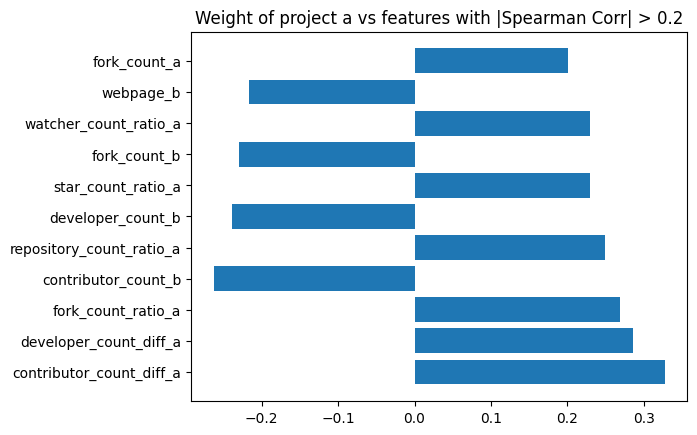

In [ ]:
plt.title('Weight of project a vs features with |Spearman Corr| > 0.2')
plt.barh(corr_weight_a.reset_index()['index'], corr_weight_a.reset_index()['weight_a'])

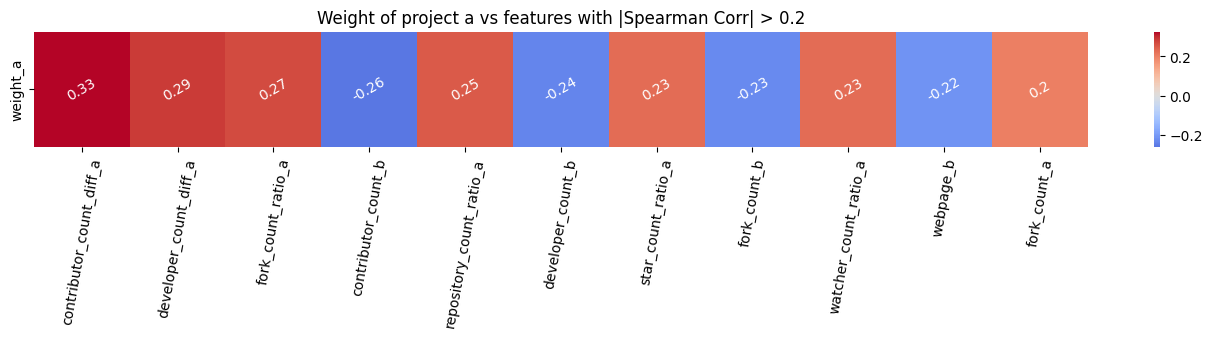

In [ ]:
# Plot of features with correlation > 0.2
threshold = 0.2
filtered_corr = corr[['weight_a']].where(abs(corr) > threshold).dropna()
filtered_corr = filtered_corr.drop(
    labels=['weight_a', 'weight_b']
).sort_values(by='weight_a', key=abs, ascending=False)
high_corr_cols = list(filtered_corr.index)

plt.figure(figsize=(17, 1.5))
corr_heatmap = sns.heatmap(
    filtered_corr.T, annot=True, cmap='coolwarm', center=0,
    annot_kws={"size": 10, "rotation": 30}
)
plt.title('Weight of project a vs features with |Spearman Corr| > 0.2')
corr_heatmap.set_xticklabels(corr_heatmap.get_xticklabels(), rotation=80)
plt.show()


In [ ]:
def features_corr_plot(df):
  df = df.copy()
  corr_features_05 = df.drop(columns={'id'}).corr(method='spearman')

  heatmaps = []

  for i in corr_features_05.iterrows():
    lst_k = []
    lst_cols = []
    for k, j in zip(i[1], corr_features_05.columns):
      if (abs(k) >= 0.9) & (abs(k) != 1):
        lst_k.append(k)
        lst_cols.append(j)
    if len(lst_k) > 0:
      df = pd.DataFrame(lst_k, index=lst_cols, columns=[f'{i[0]}'])
      heatmaps.append(df.T)

  num_dfs = len(heatmaps)
  print("Heatmaps length: ", len(heatmaps), "\n\n")
  cols = 5
  rows = 6

  fig, axs = plt.subplots(rows, cols, figsize=(17, 17))
  axs = axs.flatten()

  for i, df in enumerate(heatmaps):
    if df.shape[1] > 6:
      annot_kws={"size": 7}
    else:
      annot_kws={"size": 11}
    corr_heatmap = sns.heatmap(
          df, ax=axs[i], annot=True, cmap='coolwarm', cbar=False,
          annot_kws=annot_kws
    )
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels(corr_heatmap.get_xticklabels(), rotation=80)
    axs[i].set_title(df.index[0])

  for j in range(i + 1, len(axs)):
      axs[j].set_visible(False)

  plt.subplots_adjust(hspace=6, wspace=0.2)
  plt.show()


Heatmaps length:  20 




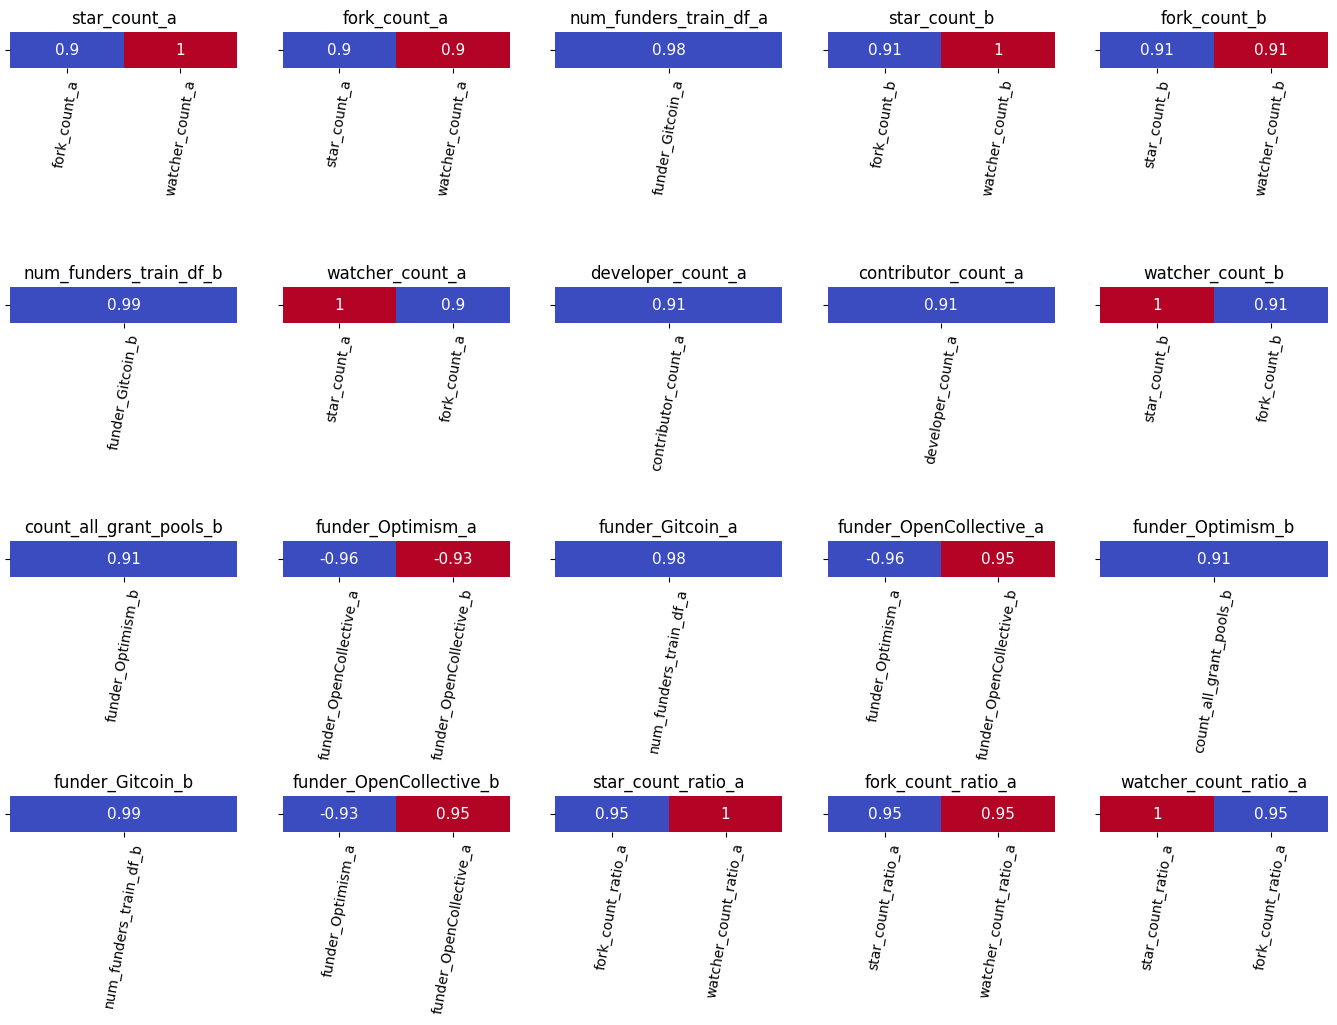

In [ ]:
features_corr_plot(df_final_train.drop(columns=['weight_a', 'weight_b']))

In [ ]:
'''
Features with significant Spearman coefficient (>0.9)
Same for both train and validation dataset.
'''

high_spearman = [
    ('star_count_a', 'fork_count_a'),
    ('star_count_a', 'watcher_count_a'),
    ('fork_count_a', 'watcher_count_a'),
    ('num_funders_train_df_a', 'funder_Gitcoin_a'),
    ('star_count_b', 'fork_count_b'),
    ('star_count_b', 'watcher_count_b'),
    ('fork_count_b', 'watcher_count_b'),
    ('num_funders_train_df_b', 'funder_Gitcoin_b'),
    ('developer_count_a', 'contributor_count_a'),
    ('count_all_grantpools_b', 'funder_Optimism_b'),
    ('funder_Optimism_a', 'funder_OpenCollective_a'),
    ('funder_Optimism_a', 'funder_OpenCollective_b'),
    ('funder_OpenCollective_a', 'funder_OpenCollective_b'),
    ('star_count_ratio_a', 'fork_count_ratio_a'),
    ('star_count_ratio_a', 'watcher_count_ratio_a')
]

cols_to_drop = [
    'fork_count_a', 'watcher_count_a', 'funder_Gitcoin_a',
    'fork_count_b', 'watcher_count_b', 'funder_Gitcoin_b',
    'developer_count_a', 'funder_Optimism_b', 'funder_Optimism_a',
    'funder_OpenCollective_b', 'fork_count_ratio_a', 'watcher_count_ratio_a'
]

df_final_train = df_final_train.drop(columns=cols_to_drop)
df_final_valid = df_final_valid.drop(columns=cols_to_drop)


### Hist Gradient Boosting try on training data

In [ ]:
# Removed highly correlated features from data

df_hgb = df_final_train.copy()

categorical_features = [
    'maintainer_a', 'language_a', 'is_fork_a', 'webpage_a', 'twitter_a',
    'funder_OpenCollective_a', 'funder_Octant_a', 'year_created_a',
    'maintainer_b', 'language_b', 'is_fork_b', 'webpage_b', 'twitter_b',
    'funder_Octant_b', 'year_created_b', 'same_language'
]

X = df_hgb.drop(columns=['weight_a', 'weight_b'])
y = df_hgb[['id', 'weight_a']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 17
)

params = {
  "max_leaf_nodes": 15,
  "random_state": 17,
  "l2_regularization": 0.05,
  "categorical_features": categorical_features
}

hist_regressor = HistGradientBoostingRegressor(
  early_stopping=False,
  **params
)

hist_regressor.fit(X_train.drop(columns=['id']), y_train['weight_a'])

y_pred = hist_regressor.predict(X_test.drop(columns=['id']))

y_pred_ranged = fix_pred_range(y_pred)
final_y_pred = pd.DataFrame({
    'id': np.array(X_test['id']),
    'pred': np.array(y_pred_ranged).round(11)
})

model_name = "HistGradientBoostingRegressor"

model_eval(model_name, params, X_test.drop(columns=['id']), y_test['weight_a'], final_y_pred['pred'])


`Model name:` HistGradientBoostingRegressor

`Model parameters:`

max_leaf_nodes
random_state
l2_regularization
categorical_features

`Features:`

maintainer_a
language_a
is_fork_a
star_count_a
num_packages_a
num_dependents_in_oso_a
num_funders_train_df_a
oso_dependency_rank_a
num_repos_in_same_language_a
oso_dependency_rank_for_language_a
maintainer_b
language_b
is_fork_b
star_count_b
num_packages_b
num_dependents_in_oso_b
num_funders_train_df_b
oso_dependency_rank_b
num_repos_in_same_language_b
oso_dependency_rank_for_language_b
webpage_a
twitter_a
count_all_grant_pools_a
repository_count_a
contributor_count_a
webpage_b
twitter_b
count_all_grant_pools_b
repository_count_b
developer_count_b
contributor_count_b
funder_OpenCollective_a
funder_Octant_a
funder_Octant_b
year_created_a
year_created_b
same_language
star_count_ratio_a
num_packages_ratio_a
num_dependents_in_oso_ratio_a
num_repos_in_same_language_ratio_a
count_all_grant_pools_ratio_a
repository_count_ratio_a
developer_count_dif

In [ ]:
# Show zero features separately and make a bar plot for feature importances

result = permutation_importance(
    hist_regressor, X_test.drop(columns=['id']), y_pred, n_repeats=10, random_state=17
)

importance_df_train = pd.DataFrame({
    'Feature': X_test.drop(columns=['id']).columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)


<BarContainer object of 7 artists>

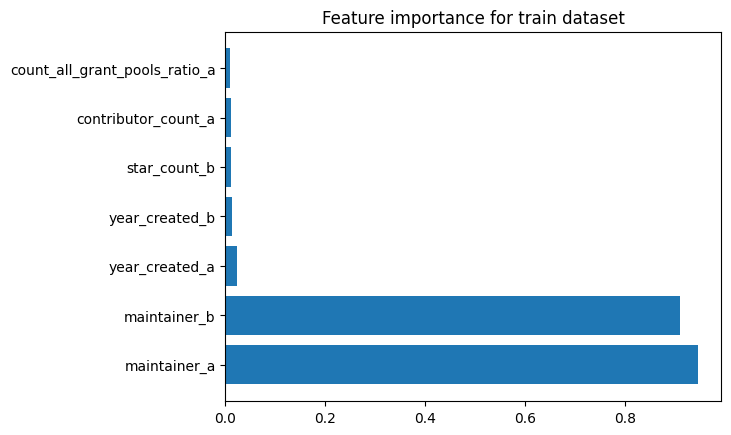

In [ ]:
plt.title('Feature importance for train dataset')
plt.barh(
    importance_df_train[importance_df_train['Importance'] > 0.008]['Feature'],
    importance_df_train[importance_df_train['Importance'] > 0.008]['Importance']
)


### Hist Gradient Boosting Hugging face submition

In [ ]:
# Removed highly correlated features from data

df_hgb = df_final_train.copy()

categorical_features = [
    'maintainer_a', 'language_a', 'is_fork_a', 'webpage_a', 'twitter_a',
    'funder_OpenCollective_a', 'funder_Octant_a', 'year_created_a',
    'maintainer_b', 'language_b', 'is_fork_b', 'webpage_b', 'twitter_b',
    'funder_Octant_b', 'year_created_b', 'same_language'
]

X_train = df_hgb.drop(columns=['weight_a', 'weight_b'])
y_train = df_hgb[['id', 'weight_a']]
X_test = df_final_valid.copy()

params = {
  "max_leaf_nodes": 15,
  "random_state": 17,
  "l2_regularization": 0.05,
  "categorical_features": categorical_features
}

hist_regressor = HistGradientBoostingRegressor(
  early_stopping=False,
  **params
)

hist_regressor.fit(X_train.drop(columns=['id']), y_train['weight_a'])

y_pred = hist_regressor.predict(X_test.drop(columns=['id']))

y_pred_ranged = fix_pred_range(y_pred)
final_y_pred = pd.DataFrame({
    'id': np.array(X_test['id']),
    'pred': np.array(y_pred_ranged).round(11)
})


In [ ]:
result = permutation_importance(
    hist_regressor, X_test.drop(columns=['id']), y_pred, n_repeats=10, random_state=17
)

importance_df_test = pd.DataFrame({
    'Feature': X_test.drop(columns=['id']).columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)


<BarContainer object of 6 artists>

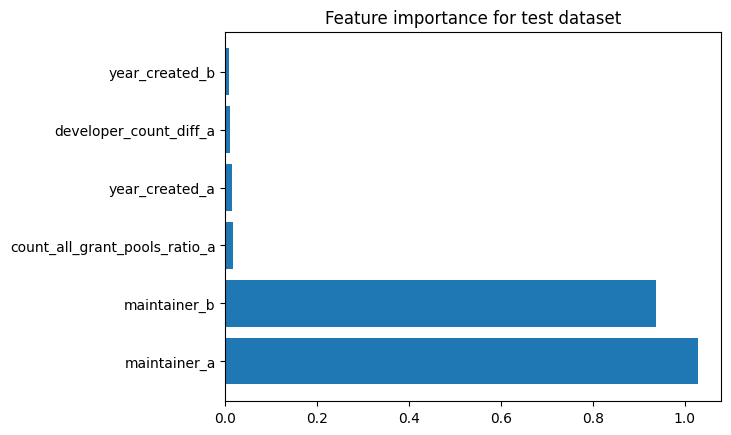

In [ ]:
plt.title('Feature importance for test dataset')
plt.barh(
    importance_df_test[importance_df_test['Importance'] > 0.008]['Feature'],
    importance_df_test[importance_df_test['Importance'] > 0.008]['Importance']
)


In [ ]:
final_y_pred.to_csv('pred_hugface.csv', index=False)